In [1]:
import sys
import os
import importlib
from pathlib import Path
sys.path.append('..')

import pandas as pd
import numpy as np
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import data.dataframe_preparation as preparation
import data.utils.plotting as plotting

# Make sure to reimport the local modules so changes in there are captured
importlib.reload(preparation)
importlib.reload(plotting)

# Config
OVERRIDE_RAW_OUTPUT = False
OVERRIDE_TF_OUTPUT = False
path = os.path.abspath("../input_files/files")

# Set up plotting
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # rc={'figure.figsize':(8,6)})
sns.set_style('ticks')

In [8]:
# Create raw file if not exits
raw_file = Path(os.path.join(path, 'raw_dataset.csv'))
if raw_file.is_file() and not OVERRIDE_RAW_OUTPUT:
    raw_df = pd.read_csv(raw_file)
else:
    raw_df = preparation.get_df(input_path=path, report_type_mappings={"CSR": "SR"}, selected_report_types={"AR", "SR", "20F"}, include_page_no=False)
    raw_df.to_csv(os.path.join(path, raw_file))


In [9]:
# Load Term frequency file if exists
tf_file = Path(os.path.join(path, 'tf_dataset.csv'))
if tf_file.is_file() and not OVERRIDE_TF_OUTPUT:
    df = pd.read_csv(tf_file)
else:
    # Prepare
    df = raw_df
    df['text'] = df['text'].fillna('Nothing')
    
    # Define vocabulary of interest for downstream calculations
    # Note: Currently only supports Unigrams and bigrams. Would need to adapt 'ngram_range below'
    vocabulary = ['climate change', 'global warming']

    # Calculate total word count, ignoring punctuation
    # total_tokenizer = RegexpTokenizer(r'\w+')
    # df['total_word_count'] = df['text'].apply(lambda text: len(total_tokenizer.tokenize(text)))
    df['total_word_count'] = df['text'].apply(lambda text: len(preparation.spacy_tokenizer(text)))
    
    # Calculate the term frequency of the selected tokens in the vocabulary
    # count_vectorizer = CountVectorizer(ngram_range=(1,2), vocabulary=vocabulary, tokenizer=preparation.tokenize)
    count_vectorizer = CountVectorizer(ngram_range=(1,2), vocabulary=vocabulary, tokenizer=preparation.spacy_tokenizer)
    count_matrix = count_vectorizer.fit_transform(df['text'])
    count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names())
    count_df = count_df.add_prefix('count_')
    
    norm_count_arr = count_matrix / df['total_word_count'][:, np.newaxis] 
    norm_count_df = pd.DataFrame(norm_count_arr, columns=count_vectorizer.get_feature_names())
    norm_count_df = norm_count_df.add_prefix('norm_count_')
    
    # Calculate the normalized term frequency of the selected tokens in the vocabulary
    # See here for reasoning: https://mail.python.org/pipermail/scikit-learn/2018-January/002174.html
    # norm_count_vectorizer = TfidfVectorizer(use_idf=False, norm='l1', ngram_range=(1,2), vocabulary=vocabulary, tokenizer=preparation.tokenize)
    # norm_count_vectorizer = TfidfVectorizer(use_idf=False, norm='l1', ngram_range=(1,2), tokenizer=preparation.spacy_tokenizer)
    # norm_count_df = norm_count_vectorizer.fit_transform(df['text'])
    # norm_count_df = pd.DataFrame(norm_count_df.toarray(), columns=norm_count_vectorizer.get_feature_names())
    # norm_count_df = norm_count_df.add_prefix('norm_count_')
    
    # Calculate TF-IDF scores
    # tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,2), tokenizer=preparation.tokenize,  strip_accents='ascii', vocabulary=vocabulary)
    # tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,2), tokenizer=preparation.spacy_tokenizer,  strip_accents='ascii')
    # tfidf_df = tf_idf_vectorizer.fit_transform(df['text'])
    # tfidf_df = pd.DataFrame(tfidf_df.toarray(), columns=tf_idf_vectorizer.get_feature_names())
    # tfidf_df = tfidf_df.add_prefix('tfidf_')
    
    # Sort and save
    df = df.join(count_df).join(norm_count_df) # .join(tfidf_df)
    df.sort_values(by=['company', 'report_type', 'year'])
    df.to_csv(os.path.join(path, tf_file))

filtered_reports = df

/Users/david/Projects/fin-disclosures-nlp/envs/lib/python3.8/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


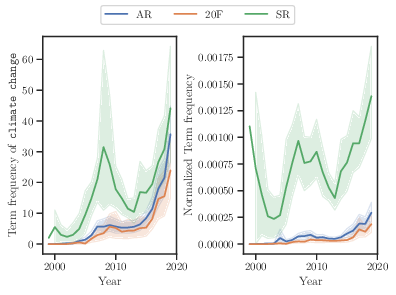

In [12]:

matplotlib.use("pgf")
matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
})

# Setup plot
fig, axs = plt.subplots(ncols=2)

"""
report_type_total_chart = sns.lineplot(
    ax=axs[0], 
    x="year", 
    y="total_word_count", 
    data=df, 
    hue="report_type", 
    markers=True, 
    dashes=True,
)
report_type_total_chart.set(ylabel="Total number of words", xlabel="Year")
for label in report_type_total_chart.xaxis.get_ticklabels()[::2]:
    pass
    # label.set_visible(False)
"""
category_column = "report_type"

report_type_count_chart = sns.lineplot(ax=axs[0], x="year", y="count_climate change", data=df, hue=category_column, markers=True, dashes=False)
report_type_count_chart.set(ylabel="Term frequency of \\texttt{climate change}", xlabel="Year")

report_type_norm_count_chart = sns.lineplot(ax=axs[1], x="year", y="norm_count_climate change", data=df, hue=category_column, markers=True, dashes=False)
report_type_norm_count_chart.set(ylabel="Normalized Term frequency", xlabel="Year")
    
# report_type_tfidf_chart = sns.lineplot(ax=axs[2], x="year", y="tfidf_climate change", data=df, hue="report_type", markers=True, dashes=False)
# for label in report_type_tfidf_chart.xaxis.get_ticklabels()[::2]:
#     label.set_visible(False)
  
# Only add one legend
handles, labels = axs[1].get_legend_handles_labels()
# Note there is a "bug" (or feature?) in seaborn, leading to always include the column name
fig.legend(handles[1:], labels[1:], loc='upper center', ncol=4)
report_type_count_chart.get_legend().remove()
report_type_norm_count_chart.get_legend().remove()

plt.subplots_adjust(wspace=0.5)
    
plotting.export_to_latex(fig, 'tf_evolution')

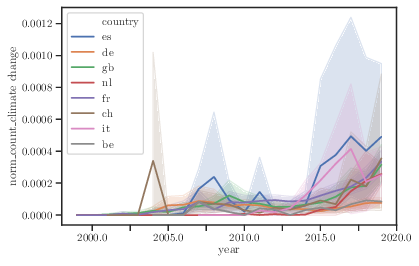

In [13]:
only_ar = df[df['report_type'].isin(['AR'])]
country_chart = sns.lineplot(x="year", y="norm_count_climate change", data=only_ar, hue="country", markers=True, dashes=False)
for label in country_chart.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
    
plotting.export_to_latex(country_chart, 'ar_country_evolution')